In [1]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)
library(glmnet)
library(glmnetUtils)

install.packages("splitTools")
library(splitTools)

install.packages('multiROC')
library(multiROC)

install.packages('dummies')
library(dummies)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ──────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.3.1
✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ ggplot2 3.1.1     ✔ forcats 0.4.0
── Conflicts ─────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: Matrix

At

In [2]:
ATAC_pred <- readRDS(snakemake@input[["input_predictions"]])
#ATAC_pred <- readRDS("../data/ATAC_predictions_train_20_predict_80/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")

head(ATAC_pred)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_39,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,-0.405123632,0.59187320,-0.29125018,-0.58276010,0.3792968,-0.04366948,0.9183014,0.7664238,0.9980457,-1.0572778
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,-0.849313481,0.39431325,0.05197526,-0.36318168,0.1744439,-0.13785162,0.5392077,0.3942941,1.7972449,-0.3619464
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,-0.871941533,-0.06389996,-0.22907645,-0.32470631,-0.6251958,0.17051719,0.6882020,0.1744819,1.4357406,-0.2330366
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,-0.005893625,0.18185487,0.32387927,0.04577069,0.2752394,0.22750427,0.6333635,0.8413436,1.2819797,0.5629469
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,-0.067895629,-0.05197828,-0.18308631,-0.70242368,-0.4281903,-0.06235782,1.0764914,1.1411410,0.8795170,-0.4910720
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,-0.735310376,0.36325245,0.20814984,-0.50307962,0.2609116,0.53933999,1.0772367,0.6906960,1.7696570,-0.4181884


In [3]:
sample_types <- readRDS(snakemake@input[["input_sample_types"]])
#sample_types <- read.table(file = "../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [4]:
data <- merge(ATAC_pred, sample_types, by="sample")
#data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-0.34089350,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.17629217,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,1.22409122,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,0.43571295,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,0.04951928,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,0.50968208,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,Ovarian_Cancer


In [5]:
data %>% group_by(sample_type) %>% summarize(n = n())
data <-subset(data, sample_type != "Duodenal_Cancer")
data$sample_type <- as.factor(data$sample_type)
data <- data %>% droplevels("Duodenal_Cancer")
data %>% group_by(sample_type) %>% summarize(n = n())

sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Duodenal_Cancer,1
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


In [6]:
data <- data %>% select(-sample)
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type
0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,1.45146500,...,-0.34089350,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,Gastric_cancer
1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,0.04814456,...,-0.17629217,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,Gastric_cancer
0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,1.33462998,...,1.22409122,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,Gastric_cancer
1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,0.97671516,...,0.43571295,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,Gastric_cancer
0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,0.76308429,...,0.04951928,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,Ovarian_Cancer
0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,0.64706533,...,0.50968208,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,Ovarian_Cancer


In [7]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

nested_CV_lasso <- function(data, k_inner_cv, k_outer_cv){
    
    y_all <- data %>% dplyr::select(sample_type) %>% as.matrix()
    classes <- unique(y_all)
    
    X <- data %>% dplyr::select(-sample_type) %>% as.matrix() 
    observed <- y_all
    return_tibble <- tibble(observed = rep(data$sample_type, k_outer_cv), 
                            CV_rep = rep(1:k_outer_cv, each=nrow(data)))
    
    for(class in 1:length(unique(y_all))){
        y <- ifelse(y_all==classes[class], 1, 0)
        message(y)
        return_vector_for_class <- c()
        
        for (i in 1:k_outer_cv){ # repeated Cross-validation loop
            
            set.seed(i)
            #cvfolds <- cut(1:nrow(data), breaks = k_inner_cv, labels = F)
            folds <- create_folds(y, k = k_inner_cv)
            #cvfolds <- sample(cvfolds)

            predicted <- rep(NA, nrow(data))
                                
            for (fold in folds){
                #rows      <- which(cvfolds==n)
                testdata  <- X[-fold,]
                traindata <- X[fold,]
                train_y <- y[fold,]

                ########### nested CV to find best alpha and lambda on train folds ###########
                set.seed(0) # alpha
                lasso_cva <- cva.glmnet(traindata, train_y, nfolds = 10, family = "binomial")
                enet_performance <- data.frame(alpha = lasso_cva$alpha)
                models <- lasso_cva$modlist
                enet_performance$cvm <- vapply(models, get_cvm, numeric(1))
                minix <- which.min(enet_performance$cvm)
                best_alpha <- lasso_cva$alpha[minix]

                set.seed(0) # lambda
                lasso_cv <- cv.glmnet(traindata, 
                                      train_y, 
                                      alpha = best_alpha, 
                                      standardize = TRUE, 
                                      nfolds = 10, 
                                      family = "binomial")
                message(plot(lasso_cv))
                lambda_cv <- lasso_cv$lambda.min

                message("best_alpha")
                message(best_alpha)
                message("best_lambda")
                message(lambda_cv)
                ####################################################################

                fit       <- glmnet(traindata, train_y, family = "binomial", alpha = best_alpha, lambda = lambda_cv)
                tmp       <- predict(fit, s=lambda_cv, testdata, type = "response")
                #IRdisplay::display(tmp)
                predicted[-fold] <- tmp
                }

            return_vector_for_class <- c(return_vector_for_class, predicted)
        }  # end of outer cv loop  
        return_tibble <- cbind(return_tibble, tibble("{classes[class]}_pred" := return_vector_for_class))
    } 
    
    return(return_tibble)
}

111100000000000000000011111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, 

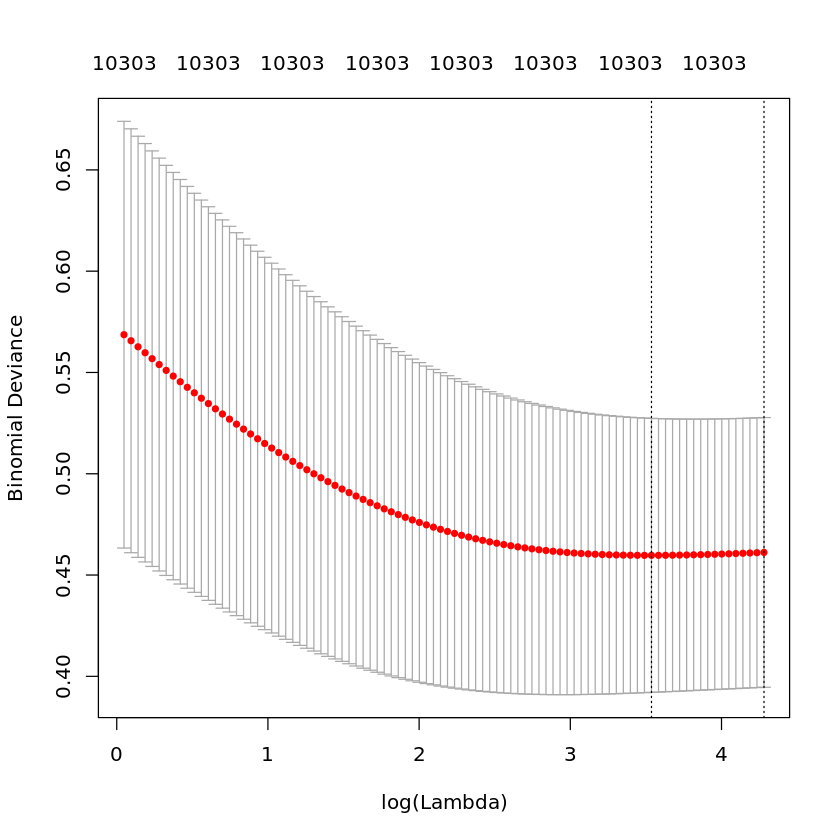


best_alpha
1
best_lambda
0.0707897448852822
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class ha

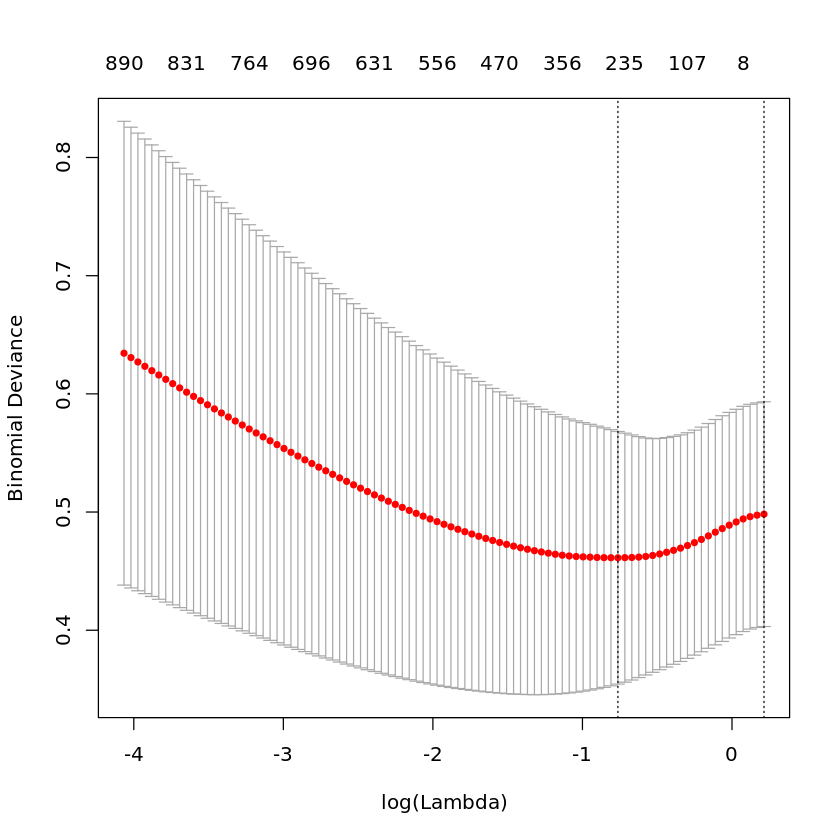


best_alpha
0.064
best_lambda
0.393483567384604
000011111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111001100000000000000000000000000000000000000000000000111100000000000000000000


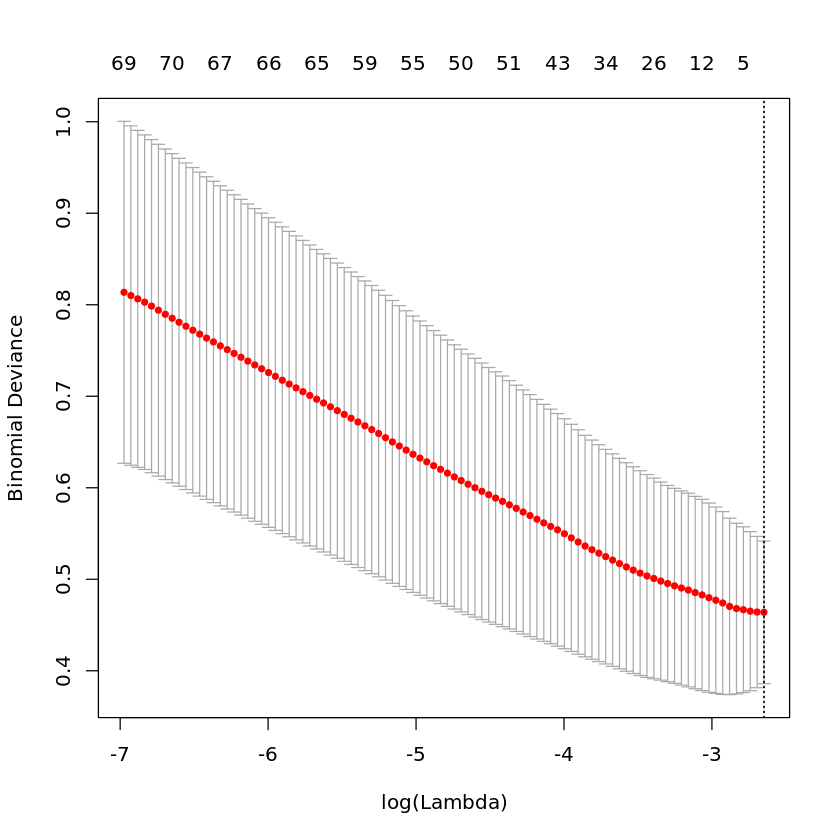


best_alpha
0.008
best_lambda
4.35629023519925
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class 

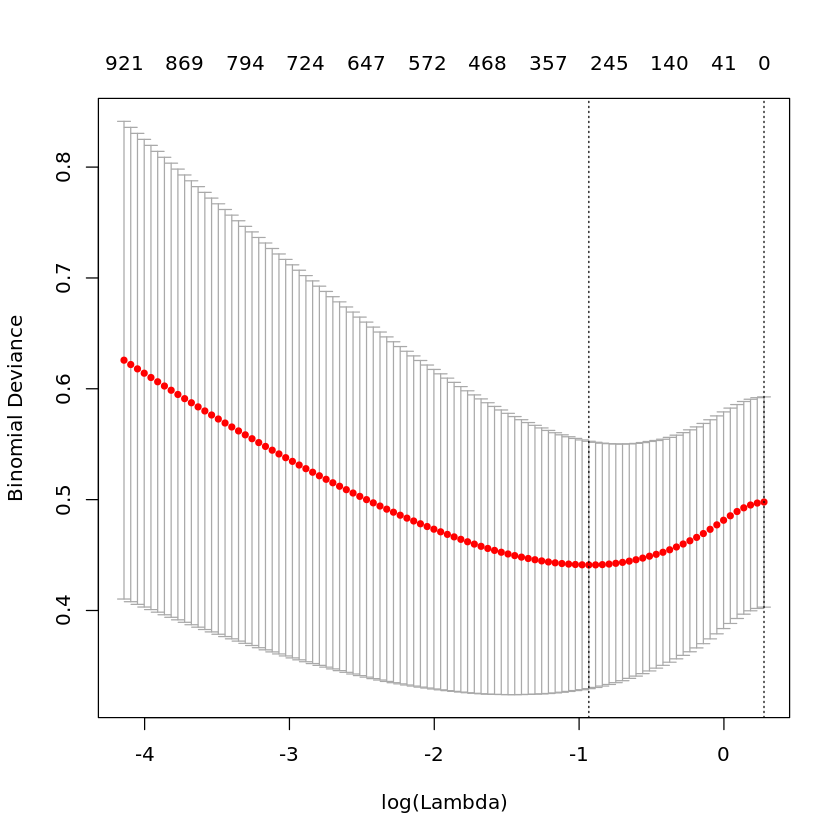


best_alpha
0.125
best_lambda
0.244292356857527


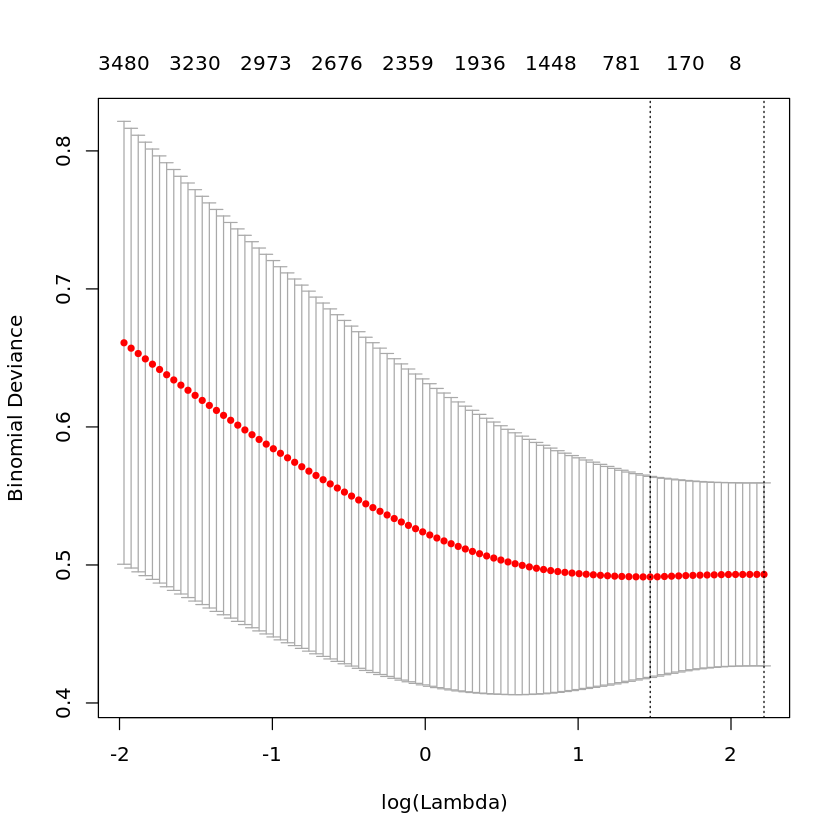


best_alpha
0.001
best_lambda
7.7755754531129
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class h

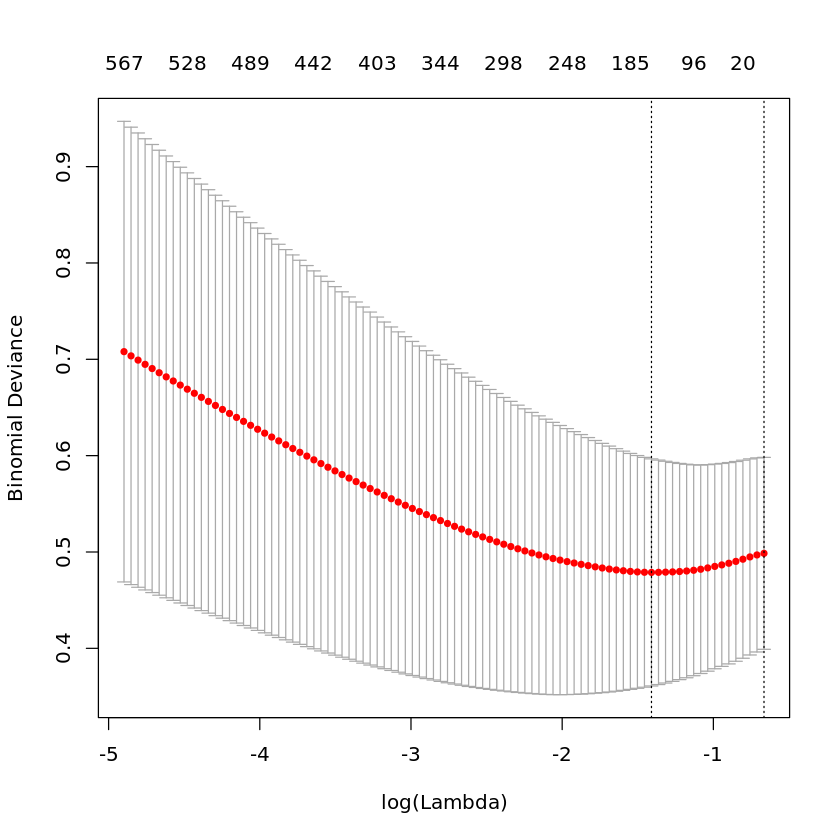


best_alpha
0.001
best_lambda
8.60897700847733
000000000000000000011100000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001110000000000000000000000000000000000000000000000000001111110000000110011111110011110000000000000000000000000000000000000011110000000000000000
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x,

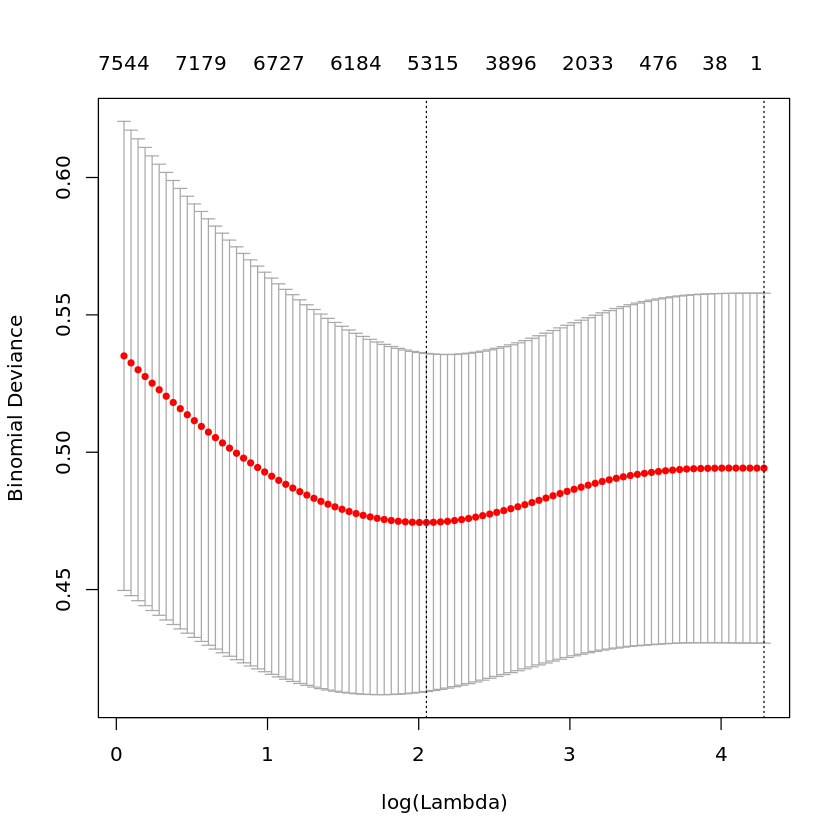


best_alpha
0.001
best_lambda
12.2730320141263


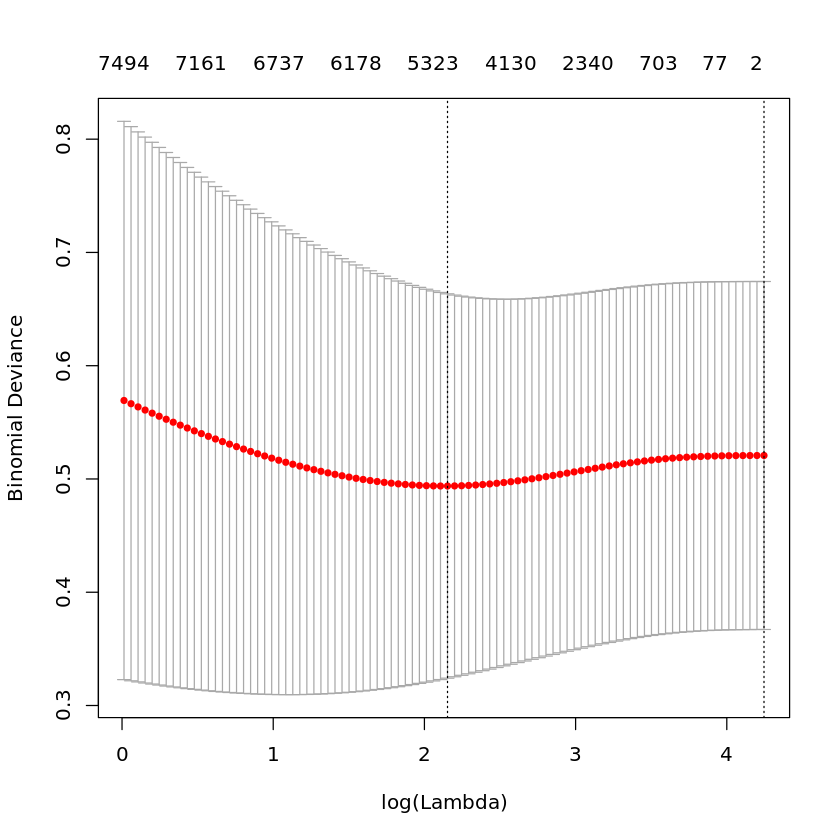


best_alpha
0.008
best_lambda
2.5302934241573


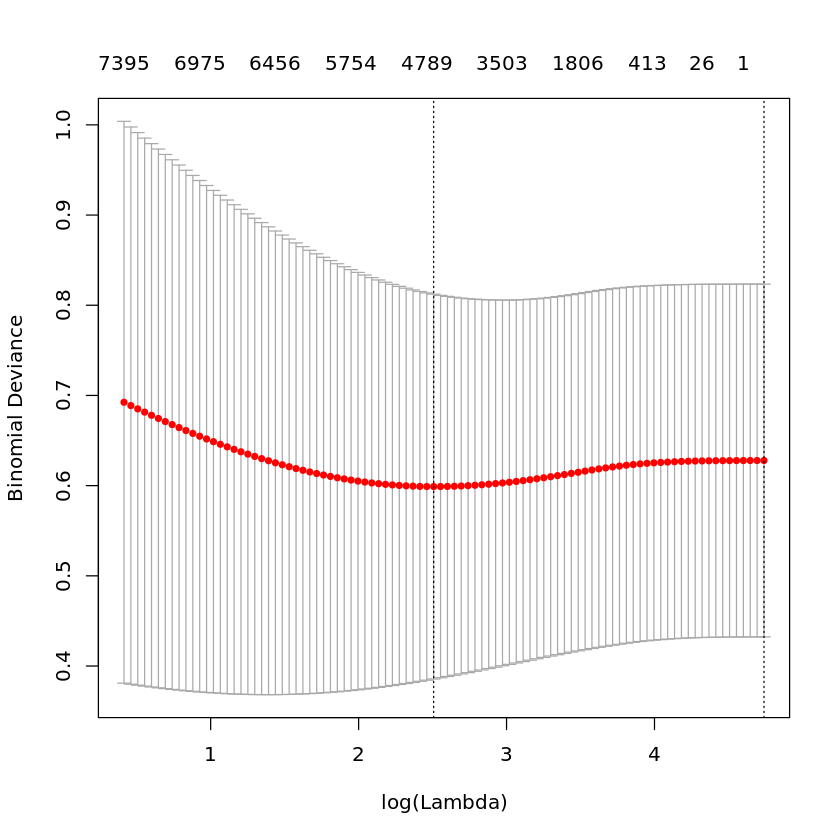


best_alpha
0.343
best_lambda
0.184119500868333


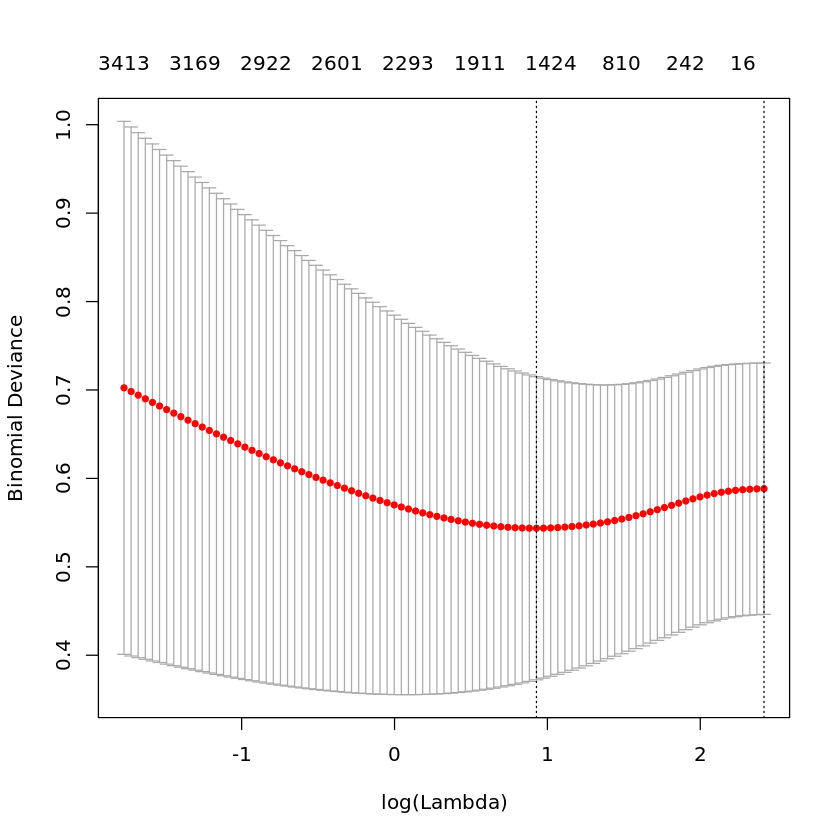


best_alpha
0.008
best_lambda
2.47842022784127
000000000000000000000000000000000000000000000111111111111111000000000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000001111111111111110000000000000000000000000000000001110000000000000000000000001100001111000000000000000000010000000000000000000000000000000000


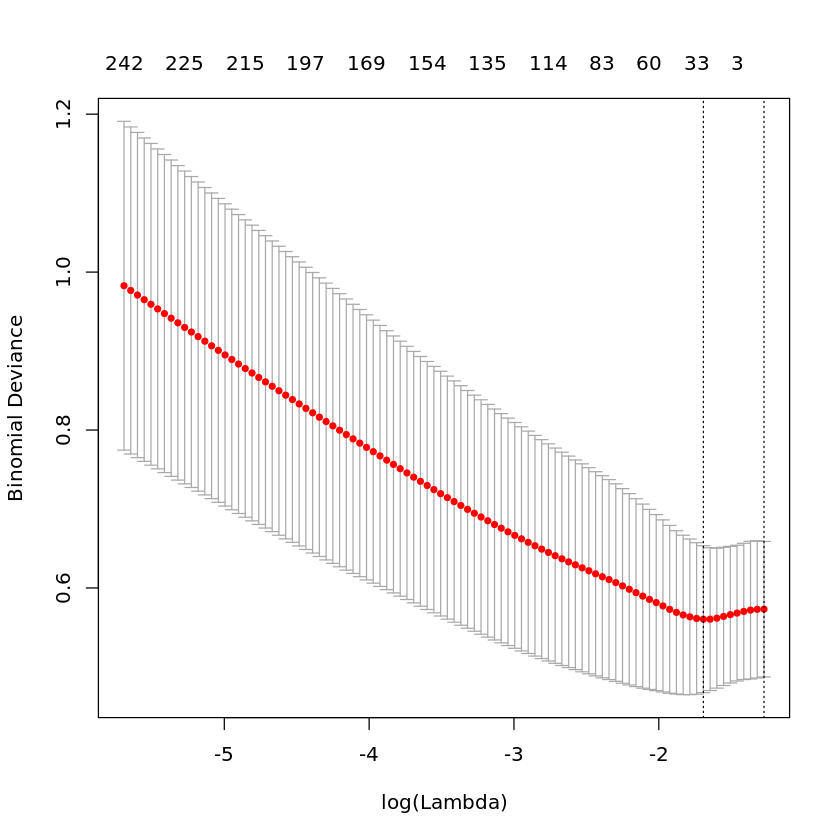


best_alpha
0
best_lambda
2.17718350024212


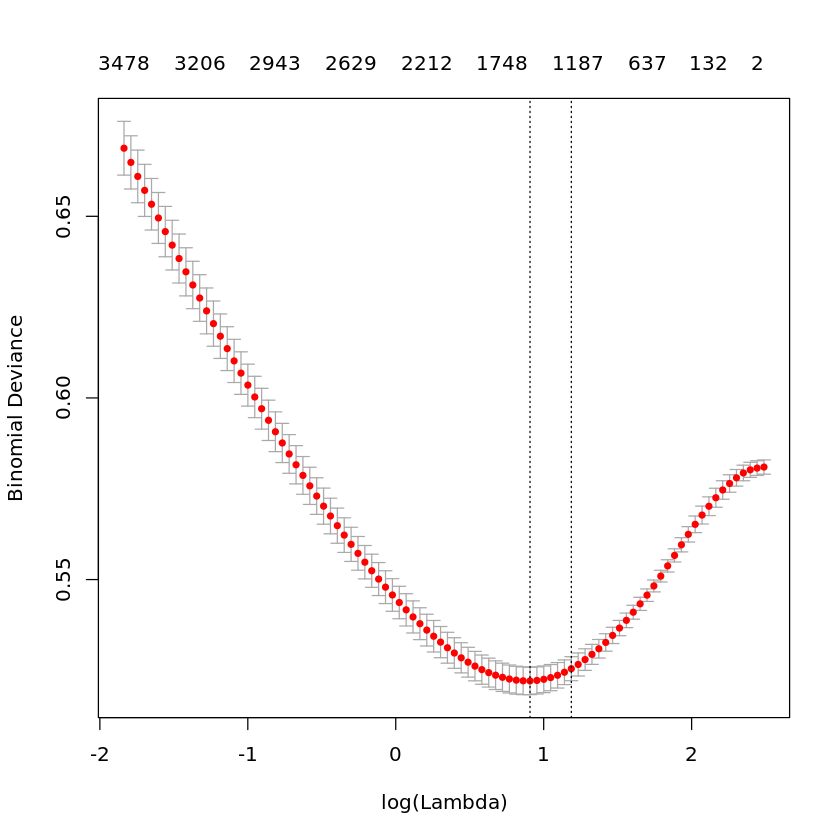


best_alpha
0.008
best_lambda
0.257810073095354


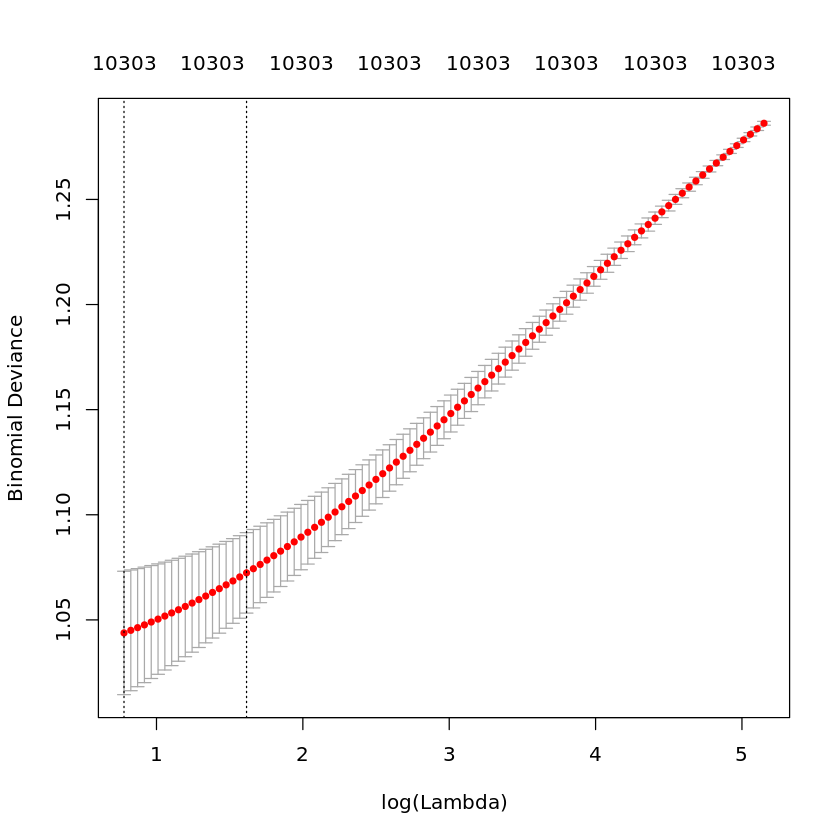


best_alpha
0.008
best_lambda
0.365347990473556


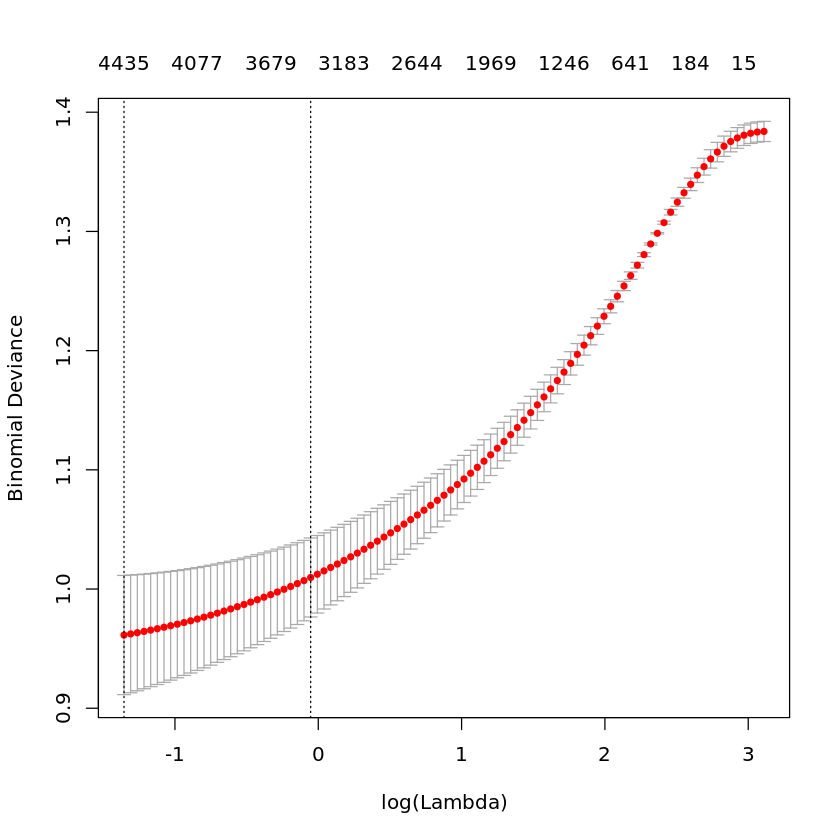


best_alpha
0
best_lambda
2.18478967151279
000000000000000000000000000000000000000000000000000000000000111111111101000000000000000000000000000001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111100000


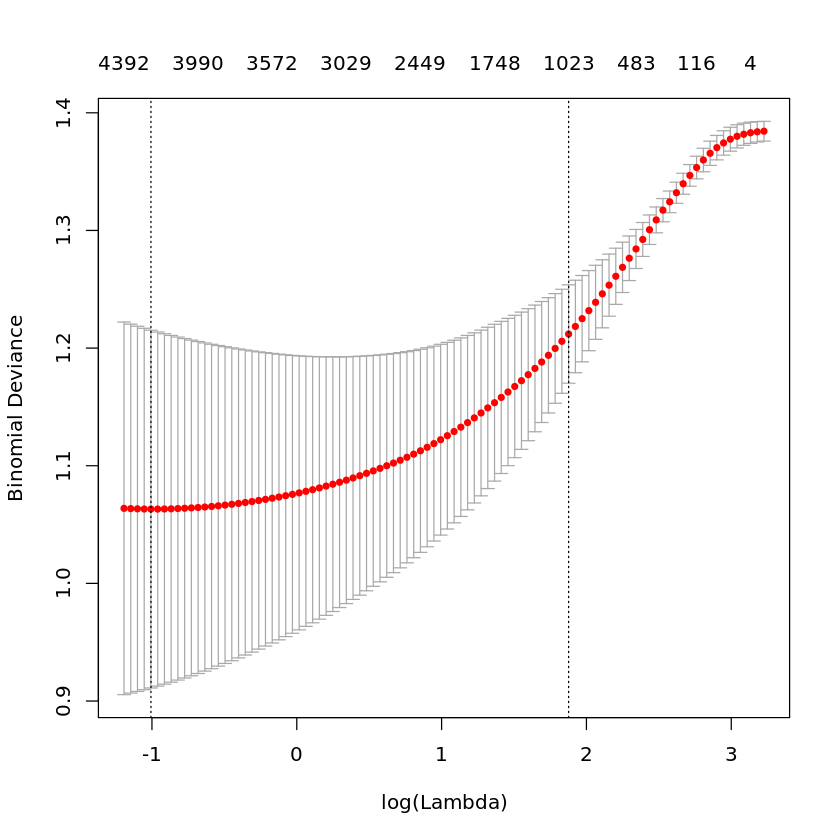


best_alpha
0
best_lambda
39.9648758301406
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has 

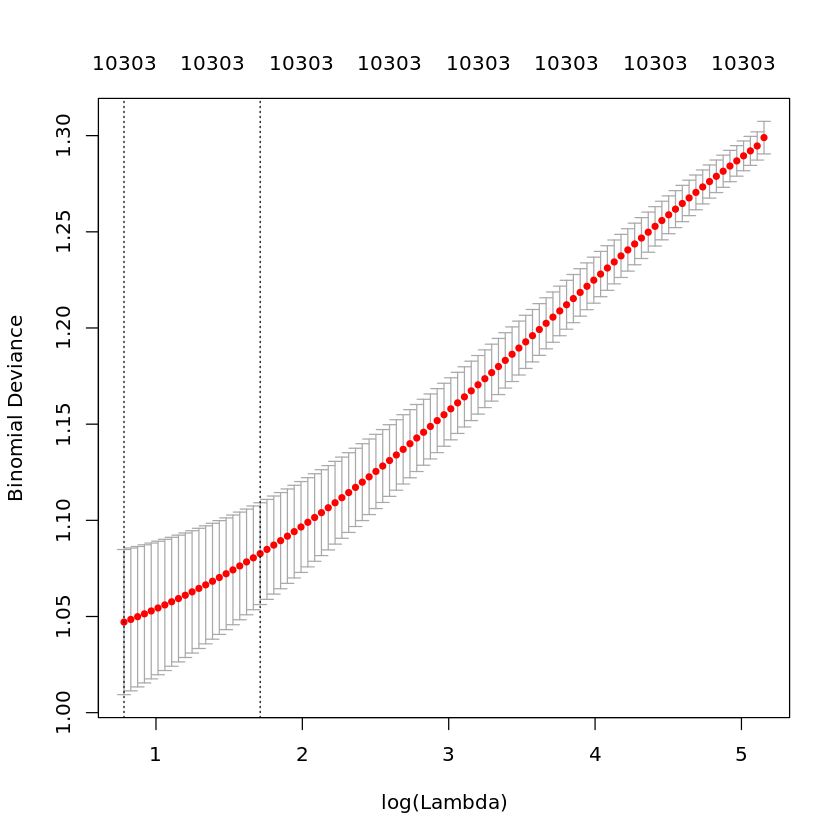


best_alpha
0.001
best_lambda
9.90614939266729
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class 

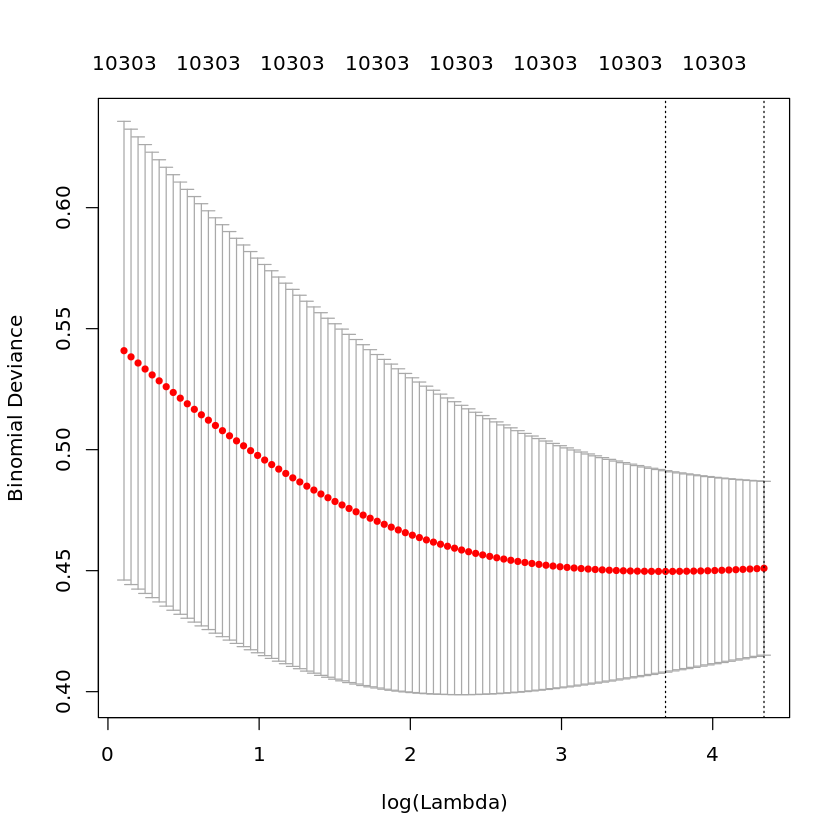


best_alpha
0.001
best_lambda
7.0832650612574
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class h

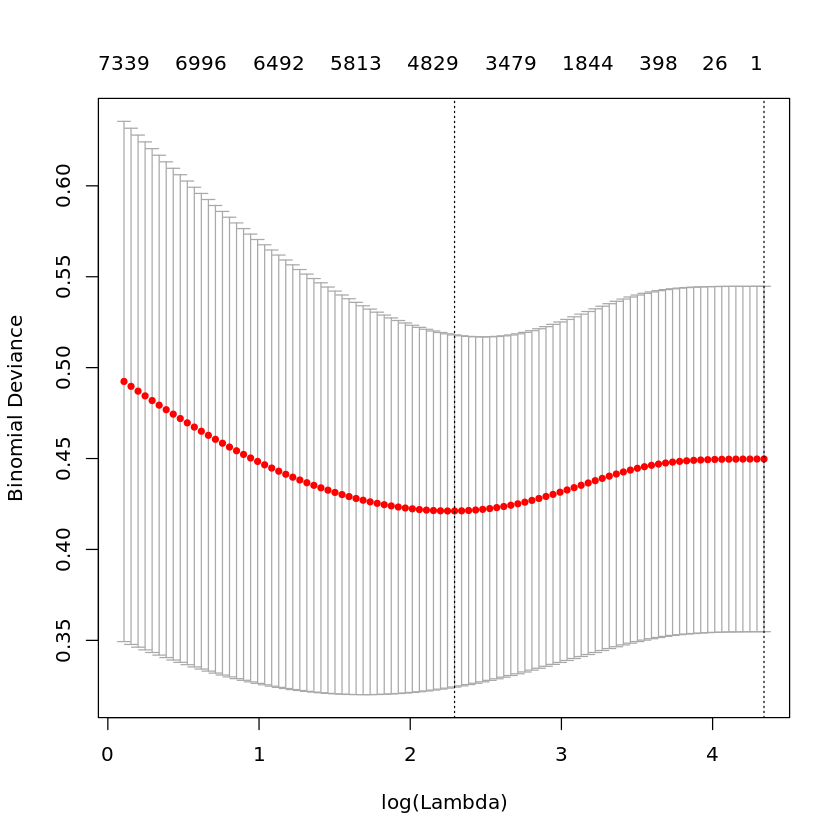


best_alpha
0.001
best_lambda
8.57214916384442
000000000000000000000000000000000000000000000000000000000000000000000010111111111111111111111111111110001111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


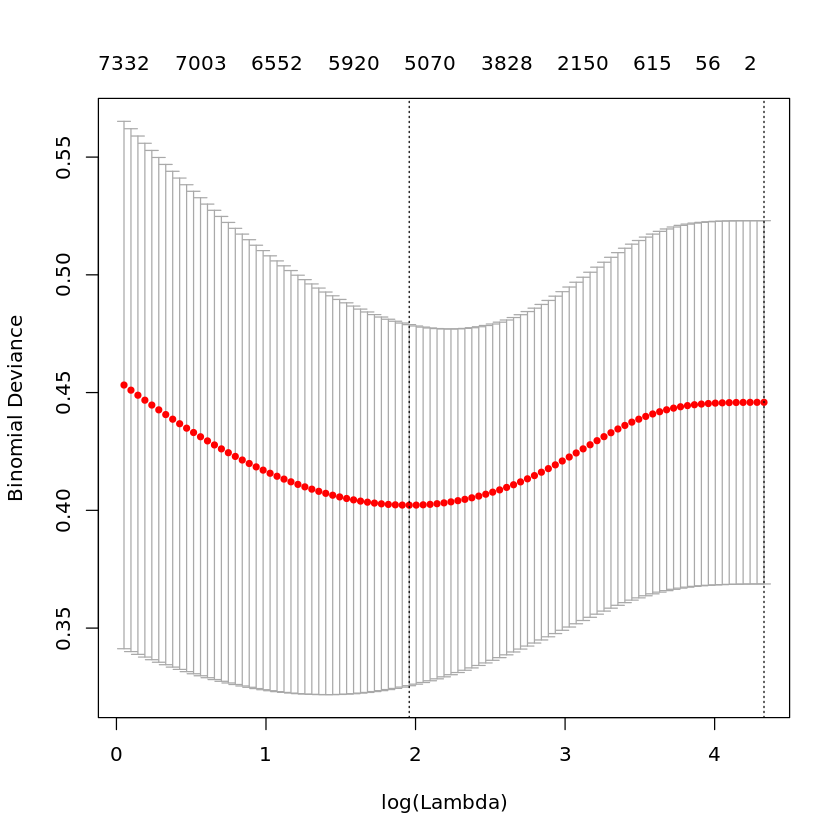


best_alpha
1
best_lambda
0.0587861742027403


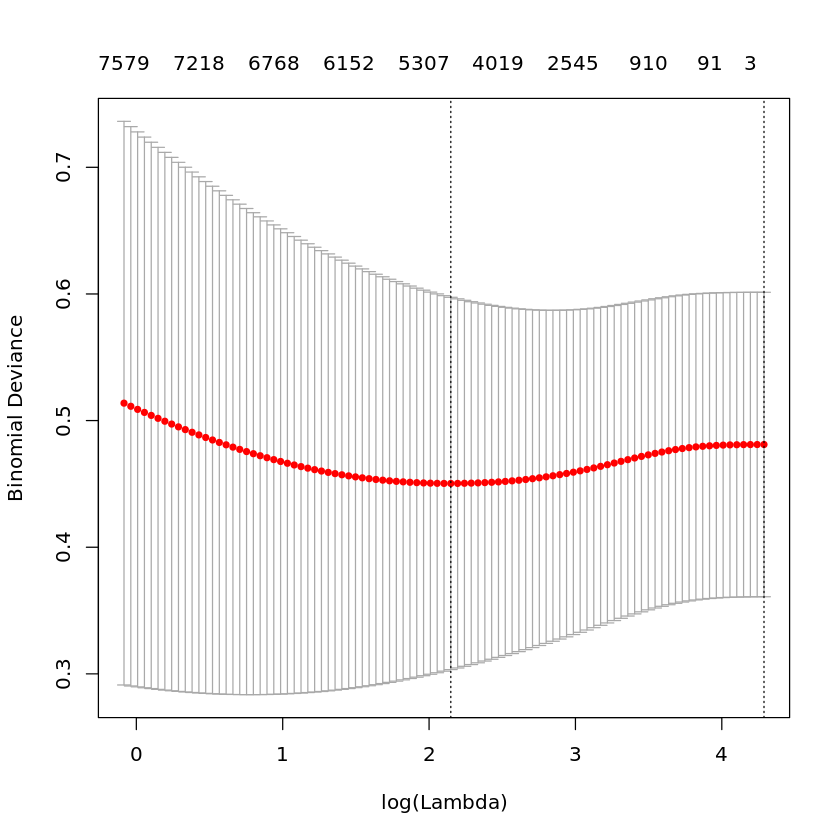


best_alpha
0
best_lambda
15.4318440821056


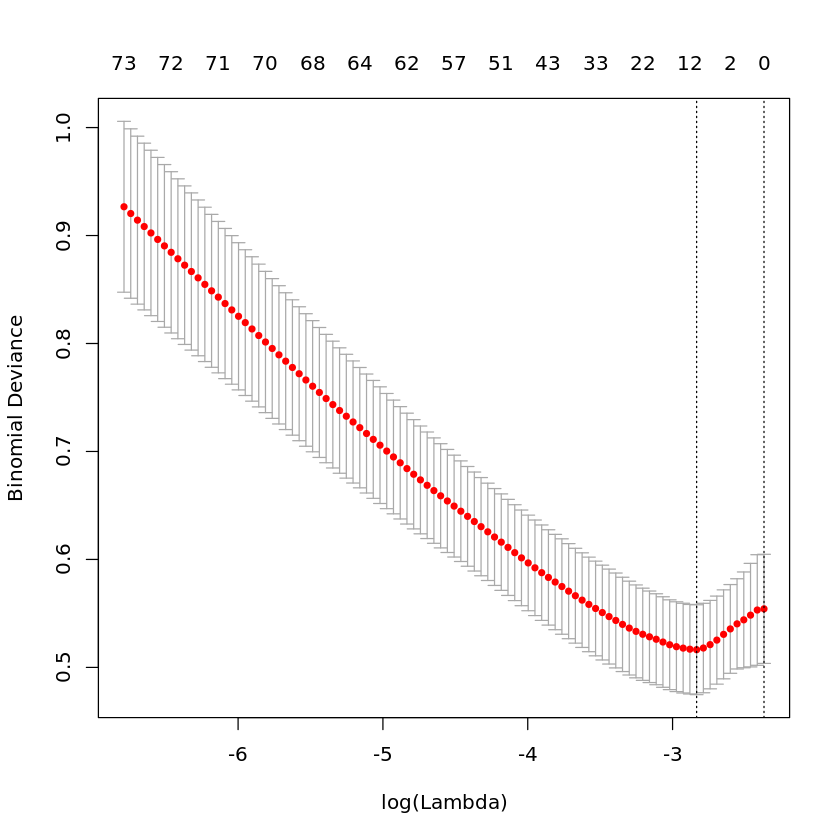


best_alpha
0
best_lambda
19.9203236639587


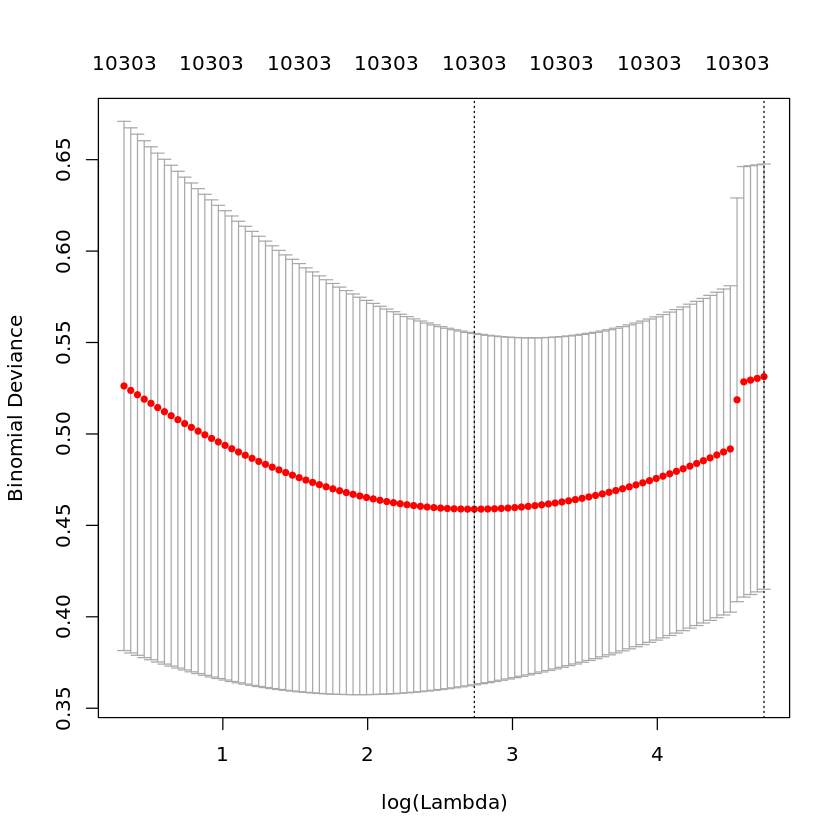


best_alpha
0.343
best_lambda
0.107114798114575
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111110000000000000000001111111111110000000000000000000000000000000000000000000000000000000000111111111111111111101111111111000000000000000000000000


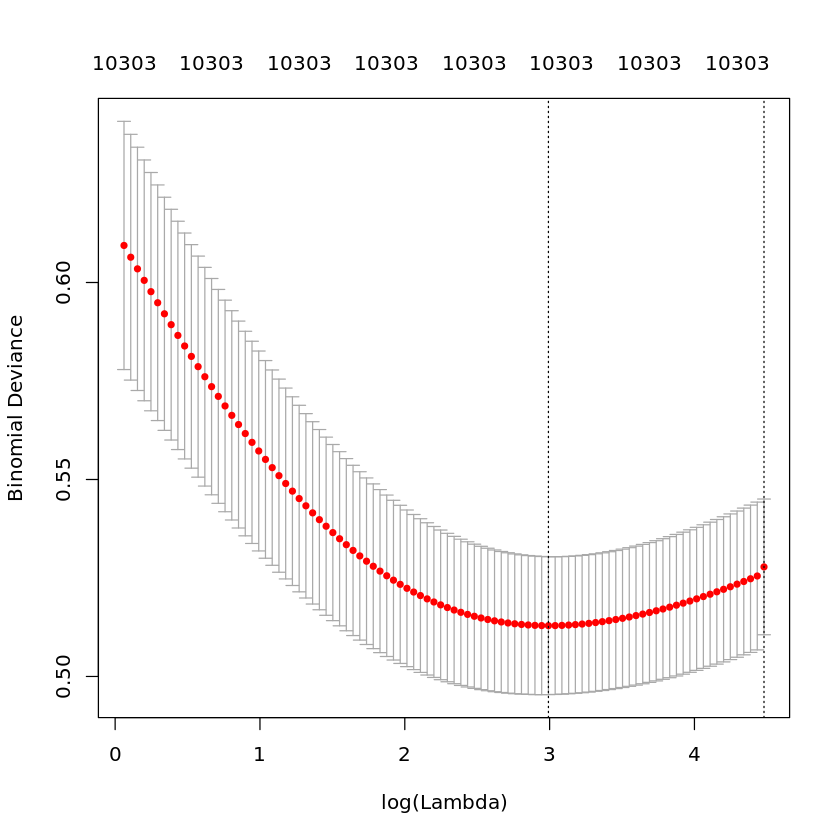


best_alpha
0
best_lambda
10.4137987511863


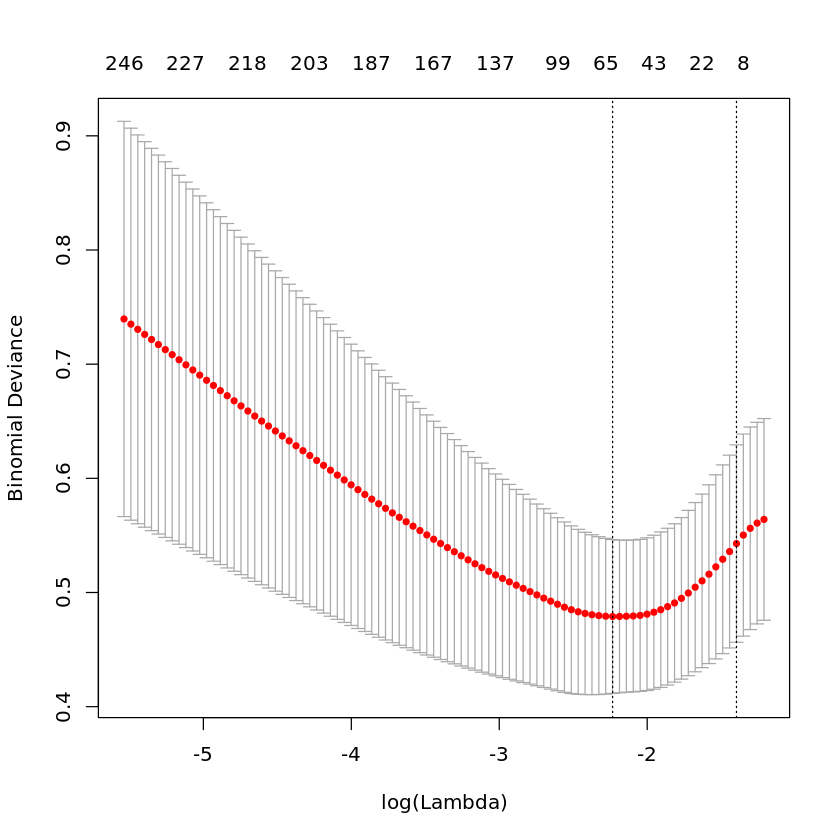


best_alpha
0.001
best_lambda
5.30835462987563


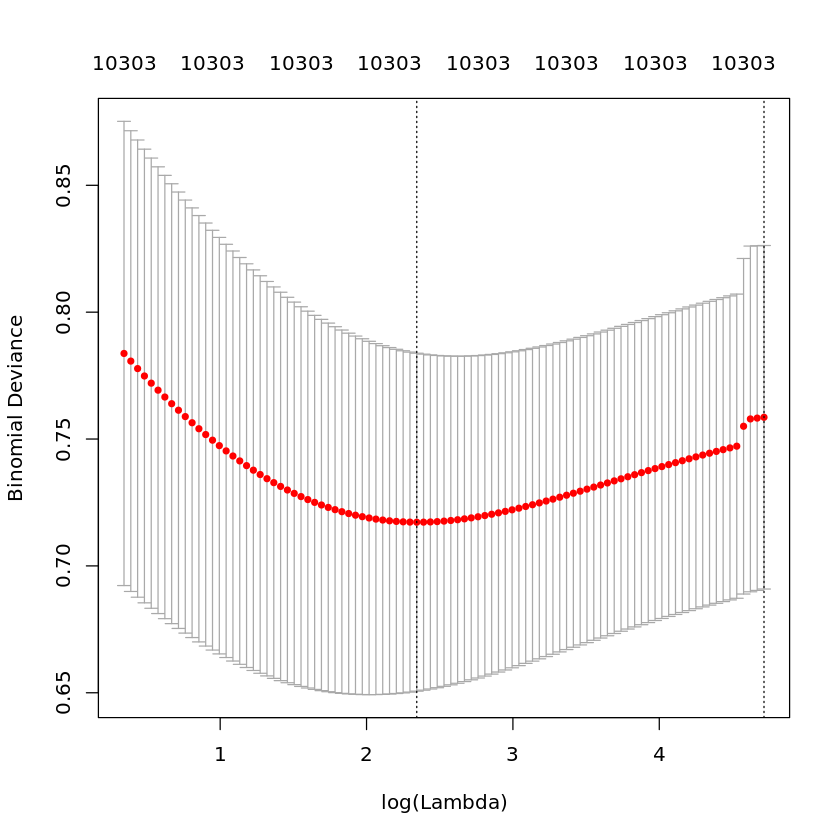


best_alpha
0
best_lambda
57.415965091489


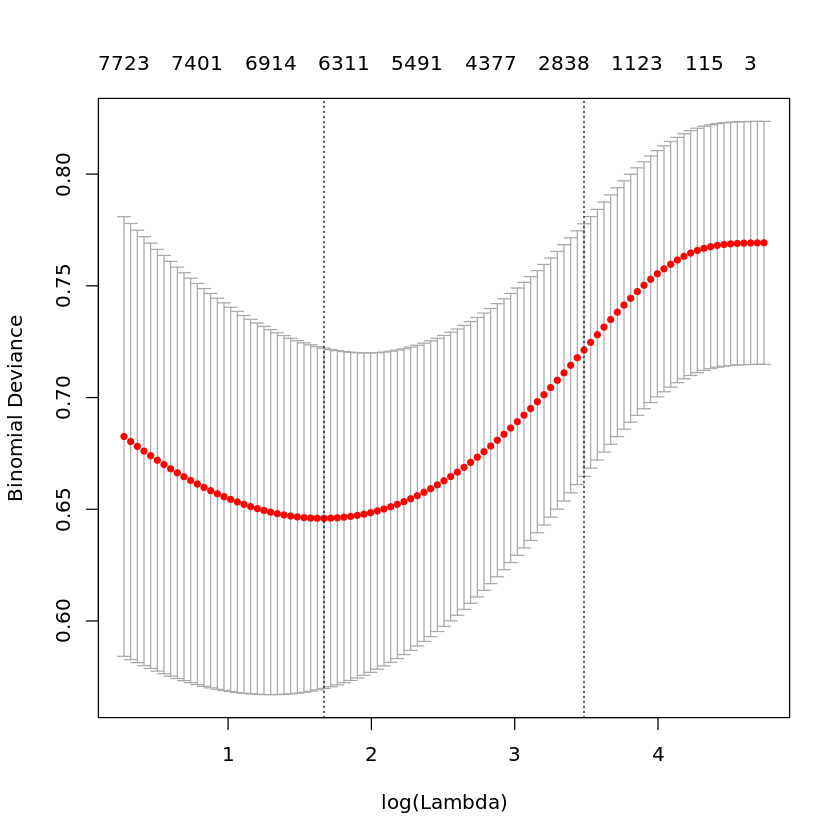


best_alpha
0
best_lambda
5.47307255279261
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.

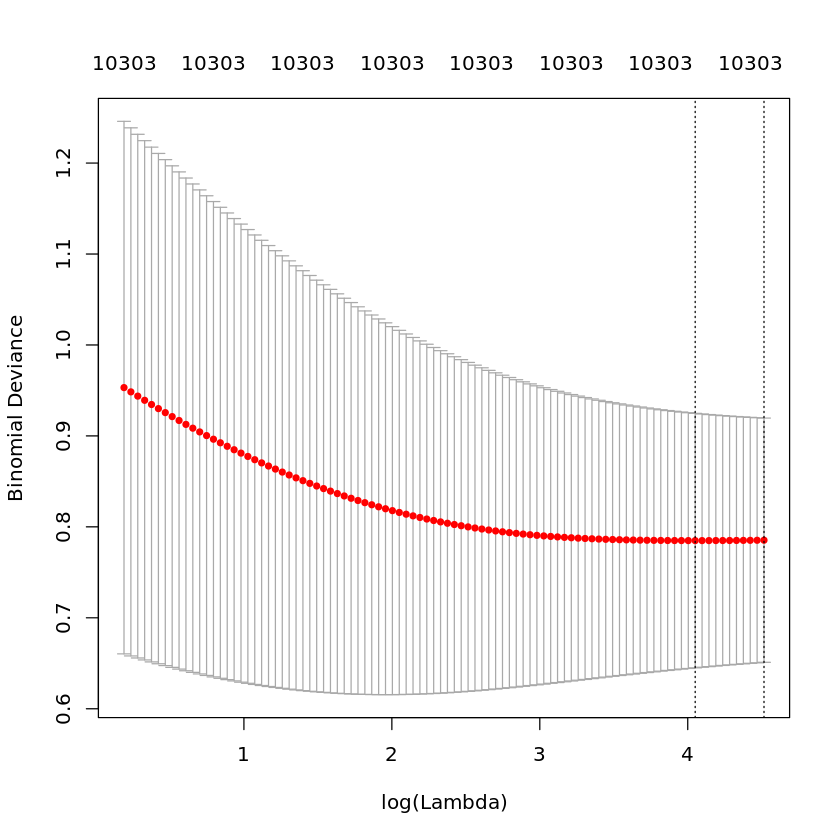


best_alpha
0
best_lambda
19.8659031383233
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has 

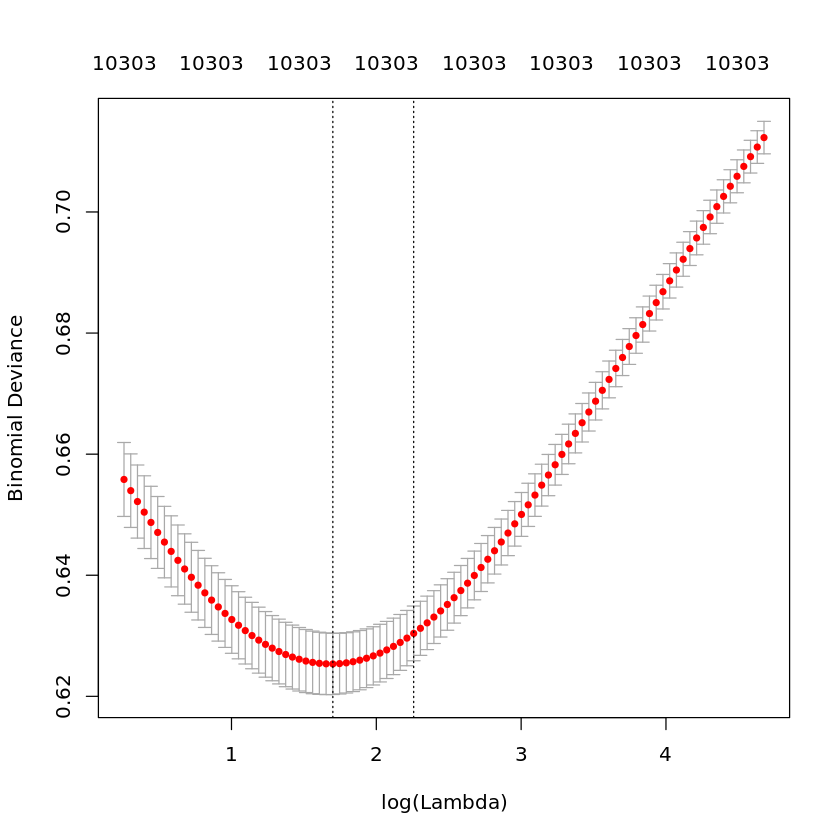


best_alpha
0
best_lambda
20.872267872475
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has f

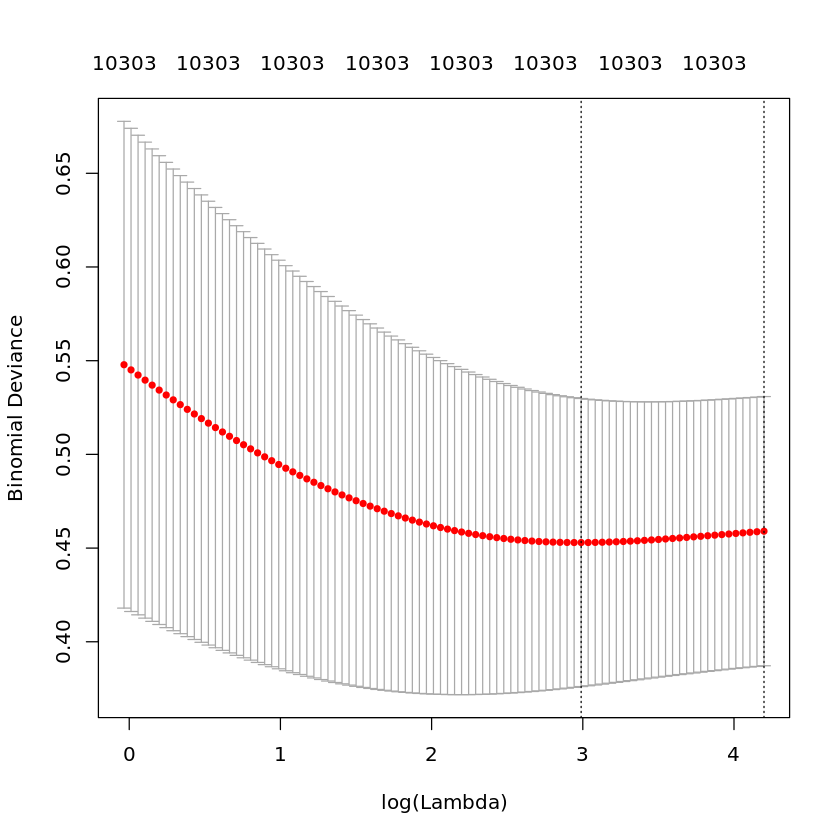


best_alpha
0.512
best_lambda
0.0388698035775938
Warning message:
“from glmnet Fortran code (error code -1); Convergence for 1th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message in getcoef(fit, nvars, nx, vnames):
“an empty model has been returned; probably a convergence issue”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous 

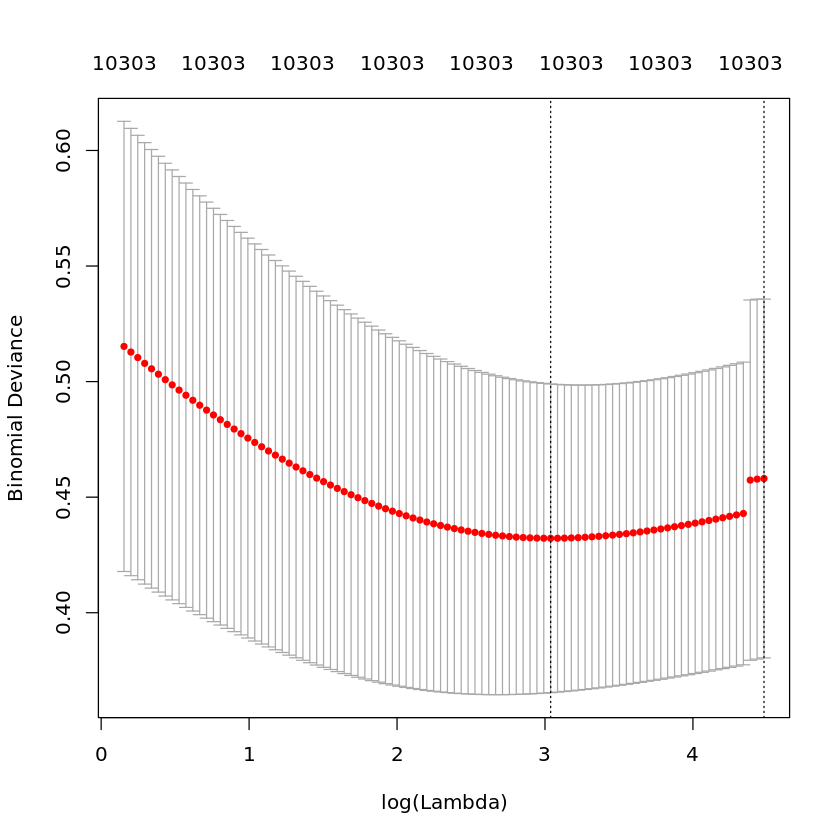


best_alpha
0
best_lambda
21.3443213904105


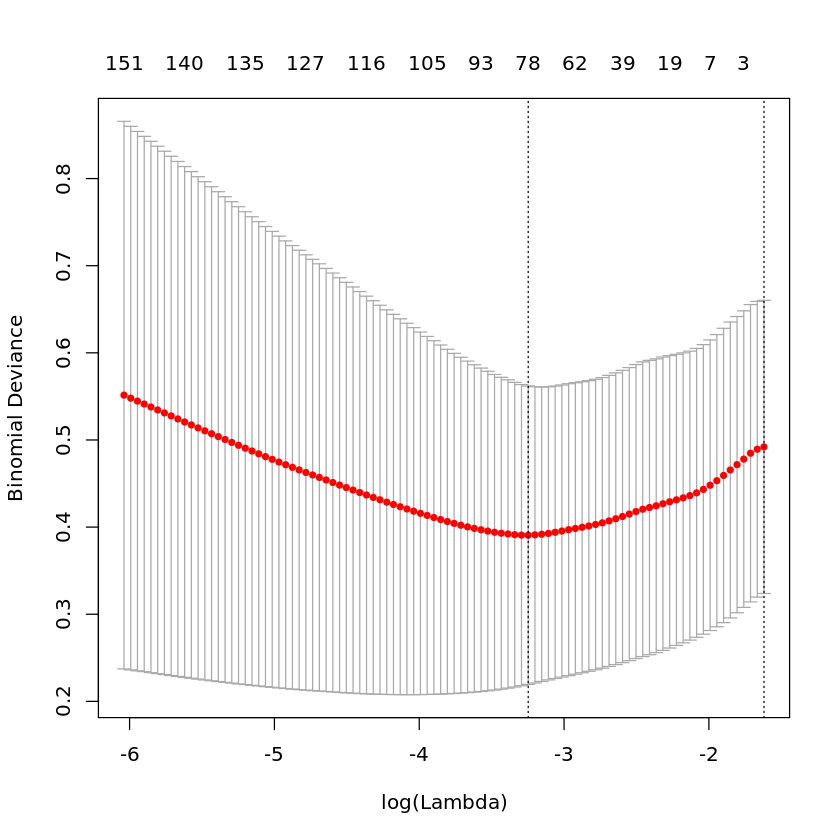

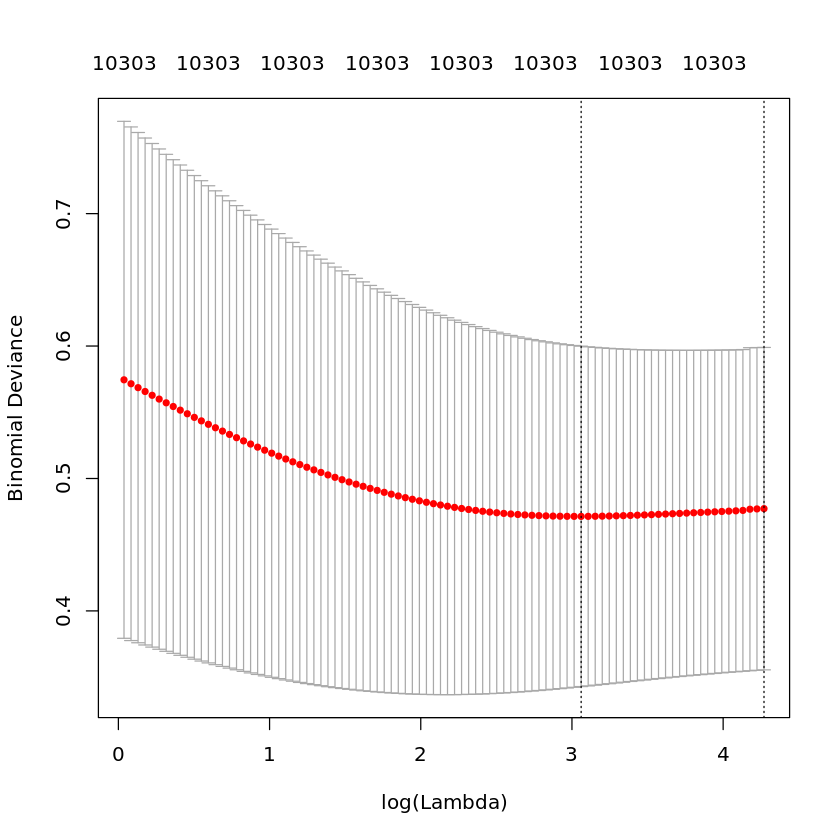

In [8]:
k_outer_cv = 10
results <- nested_CV_lasso(data, k_inner_cv = 10, k_outer_cv = k_outer_cv)

In [9]:
#results <- tibble(results, .name_repair = "unique")
head(results)

observed,CV_rep,Gastric_cancer_pred,Ovarian_Cancer_pred,Lung_Cancer_pred,Healthy_pred,Bile_Duct_Cancer_pred,Pancreatic_Cancer_pred,Breast_Cancer_pred,Colorectal_Cancer_pred
Gastric_cancer,1,0.05387850,0.06064545,0.05746754,0.595764864,0.03786233,0.03864556,0.09648218,0.03832026
Gastric_cancer,1,0.05291704,0.06671909,0.07483359,0.528530328,0.05727839,0.07632572,0.09491381,0.05613375
Gastric_cancer,1,0.01786751,0.07941185,0.05090581,0.005173199,0.18585466,0.21720326,0.06998758,0.05386588
Gastric_cancer,1,0.06244510,0.03972270,0.08428919,0.816596578,0.03090502,0.02702017,0.11525540,0.03983672
Ovarian_Cancer,1,0.05826352,0.07215566,0.07905109,0.457521536,0.03442681,0.03574153,0.07892842,0.04601747
Ovarian_Cancer,1,0.05489974,0.07548185,0.07263519,0.203148591,0.06671108,0.08387832,0.05157193,0.04901612


In [ ]:
saveRDS(results, file = snakemake@output[["lasso_output"]])

In [11]:
for ( col in 1:ncol(results)){
    colnames(results)[col] <-  sub("_pred", "", colnames(results)[col])
}
head(results)

observed,CV_rep,Gastric_cancer,Ovarian_Cancer,Lung_Cancer,Healthy,Bile_Duct_Cancer,Pancreatic_Cancer,Breast_Cancer,Colorectal_Cancer
Gastric_cancer,1,0.05387850,0.06064545,0.05746754,0.595764864,0.03786233,0.03864556,0.09648218,0.03832026
Gastric_cancer,1,0.05291704,0.06671909,0.07483359,0.528530328,0.05727839,0.07632572,0.09491381,0.05613375
Gastric_cancer,1,0.01786751,0.07941185,0.05090581,0.005173199,0.18585466,0.21720326,0.06998758,0.05386588
Gastric_cancer,1,0.06244510,0.03972270,0.08428919,0.816596578,0.03090502,0.02702017,0.11525540,0.03983672
Ovarian_Cancer,1,0.05826352,0.07215566,0.07905109,0.457521536,0.03442681,0.03574153,0.07892842,0.04601747
Ovarian_Cancer,1,0.05489974,0.07548185,0.07263519,0.203148591,0.06671108,0.08387832,0.05157193,0.04901612


## AUC calculation with pROC package == One vs. one

In [12]:
rocs <- list()
list_names <- paste0("CV_rep_", 1:k_outer_cv)
for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i) %>% select(-c(CV_rep, observed))
    res_CV <- 
    roc <- multiclass.roc(response = data$sample_type, predictor = res_CV)
    rocs[[i]] <- roc
}
names(rocs) <- c(list_names)

paste0("The AUC of the first CV repetition: ", rocs[[1]]$auc)

aucs <- c()
for (i in 1:length(rocs)){
    aucs <- c(aucs, rocs[[i]]$auc) 
}

paste0("The mean AUC of all the CV repetitions: ", mean(aucs))

[1] "The AUC of the first CV repetition: 0.730172246546534"

[1] "The mean AUC of all the CV repetitions: 0.70844458923076"

# AUC calculation with multiROC package == One vs. rest, and plotting

#### Run the multiROC and plotting for all the CV repetitions

In [13]:
Specificities <- NULL
Sensitivities <- NULL

for (i in 1:k_outer_cv){
    res_CV <- data.frame(results %>% filter(CV_rep == i) %>% select(-c(CV_rep, observed)))
    
    colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

    true_label <- dummies::dummy(data$sample_type, sep = ".")
    true_label <- data.frame(true_label)
    colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
    colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
    final_df <- cbind(true_label, res_CV)

    roc_res <- multi_roc(final_df, force_diag=T)
    
    if (i == 1){
        AUCs <- as.data.frame(t(unlist(roc_res$AUC)))
    }
    else {
        AUCs <- rbind(AUCs, as.data.frame(t(unlist(roc_res$AUC))))
    }
    
    plot_roc_df <- plot_roc_data(roc_res)
    plot_roc_df <- plot_roc_df %>% select(-Method)
    
    if (i == 1){
        Specificities <- plot_roc_df %>% select(Specificity)
        Sensitivities <- plot_roc_df %>% select(Sensitivity)
        Groups  <- plot_roc_df %>% select(Group)
    }
    else {
        Specificities <- cbind(Specificities, plot_roc_df %>% select(Specificity))
        Sensitivities <- cbind(Sensitivities, plot_roc_df %>% select(Sensitivity))
    }
    
    #IRdisplay::display(all_plot_roc_df)

}
Specificities <- tibble(Specificities, .name_repair = "unique")
Specificities <- Specificities %>% mutate(mean = rowMeans(across()))
Sensitivities <- tibble(Sensitivities, .name_repair = "unique")
Sensitivities <- Sensitivities %>% mutate(mean = rowMeans(across()))

(AUCs <- tibble(AUCs))

all_sensitivity_specificity <- tibble(Specificity = Specificities$mean, Sensitivity = Sensitivities$mean, Group = Groups$Group)
head(all_sensitivity_specificity)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“

lasso.Bile_Duct_Cancer,lasso.Breast_Cancer,lasso.Colorectal_Cancer,lasso.Gastric_cancer,lasso.Healthy,lasso.Lung_Cancer,lasso.Ovarian_Cancer,lasso.Pancreatic_Cancer,lasso.macro,lasso.micro
0.7767839,0.7485697,0.7434606,0.6927609,0.8560077,0.8174521,0.7300181,0.6897777,0.7568347,0.8244795
0.8154774,0.7256850,0.5029064,0.6492705,0.8688381,0.6856406,0.7667269,0.7011946,0.7144460,0.7984476


Specificity,Sensitivity,Group
1.0000000,0.00,Bile_Duct_Cancer
0.9974874,0.00,Bile_Duct_Cancer
0.9962312,0.02,Bile_Duct_Cancer
0.9949749,0.04,Bile_Duct_Cancer
0.9937186,0.06,Bile_Duct_Cancer
0.9924623,0.08,Bile_Duct_Cancer


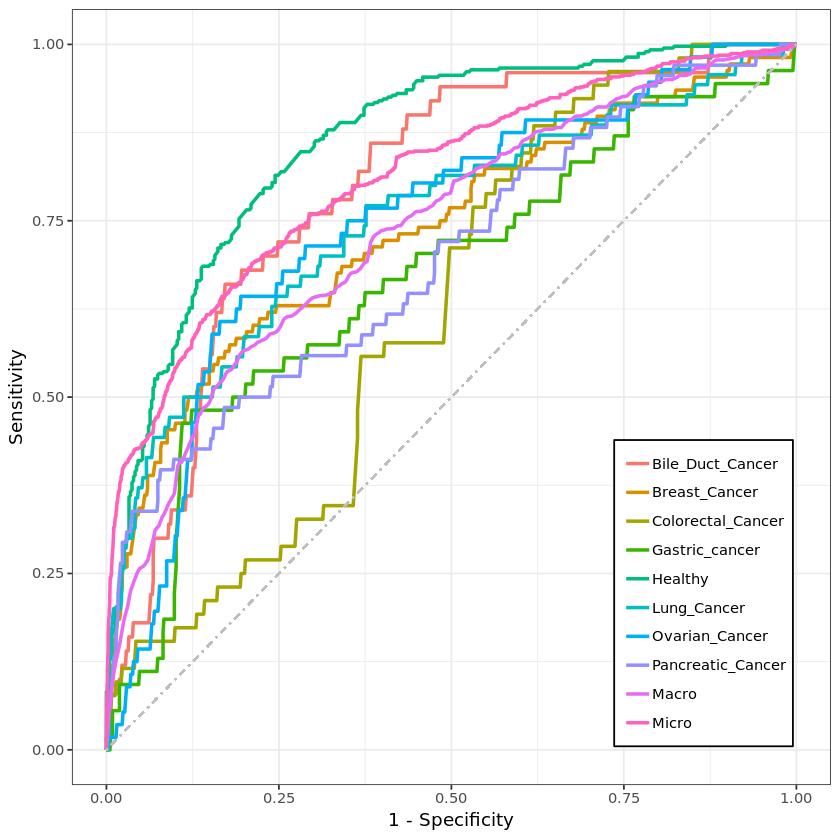

In [14]:
ggplot(all_sensitivity_specificity, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))

In [15]:
print("Mean AUC over 10 repetitions of 10-fold CV: ")
(mean_AUCs <- colMeans(AUCs[sapply(AUCs, is.numeric)]))

[1] "Mean AUC over 10 repetitions of 10-fold CV: "


lasso.Bile_Duct_Cancer     lasso.Breast_Cancer lasso.Colorectal_Cancer 
              0.7961307               0.7371274               0.6231835 
   lasso.Gastric_cancer           lasso.Healthy       lasso.Lung_Cancer 
              0.6710157               0.8624229               0.7515464 
   lasso.Ovarian_Cancer lasso.Pancreatic_Cancer             lasso.macro 
              0.7483725               0.6954862               0.7356403 
            lasso.micro 
              0.8114635

In [16]:
results01 <- tibble()

for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i)
    obs_rep <- res_CV %>% select(c(CV_rep, observed))
    res_CV <- res_CV %>% select(-c(CV_rep, observed))
    res_CV <- res_CV %>% mutate(pred01 = factor(colnames(res_CV)[apply(res_CV,1,which.max)], ordered = TRUE))
    res_CV <- cbind(res_CV, obs_rep)
    results01 <- rbind(results01, res_CV)
}

head(results01)

Gastric_cancer,Ovarian_Cancer,Lung_Cancer,Healthy,Bile_Duct_Cancer,Pancreatic_Cancer,Breast_Cancer,Colorectal_Cancer,pred01,CV_rep,observed
0.05387850,0.06064545,0.05746754,0.595764864,0.03786233,0.03864556,0.09648218,0.03832026,Healthy,1,Gastric_cancer
0.05291704,0.06671909,0.07483359,0.528530328,0.05727839,0.07632572,0.09491381,0.05613375,Healthy,1,Gastric_cancer
0.01786751,0.07941185,0.05090581,0.005173199,0.18585466,0.21720326,0.06998758,0.05386588,Pancreatic_Cancer,1,Gastric_cancer
0.06244510,0.03972270,0.08428919,0.816596578,0.03090502,0.02702017,0.11525540,0.03983672,Healthy,1,Gastric_cancer
0.05826352,0.07215566,0.07905109,0.457521536,0.03442681,0.03574153,0.07892842,0.04601747,Healthy,1,Ovarian_Cancer
0.05489974,0.07548185,0.07263519,0.203148591,0.06671108,0.08387832,0.05157193,0.04901612,Healthy,1,Ovarian_Cancer


In [17]:
error_rates <- c()
accuracies <- c()
for (i in 1:k_outer_cv){
    res_CV <- results01 %>% filter(CV_rep == i)
    error_rates <- c(error_rates, mean(as.character(res_CV$observed) != as.character(res_CV$pred01)))
    accuracies <- c(accuracies, mean(as.character(res_CV$observed) == as.character(res_CV$pred01)))
}

error_rates
accuracies

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.4893617 0.5200946

[1] 0.5106383 0.4799054

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.504728132387707"

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.495271867612293"

### for one vs rest classifier: https://stats.stackexchange.com/questions/71700/how-to-draw-roc-curve-with-three-response-variable/110550#110550

In [77]:
install.packages("ROCR")
library(ROCR)
install.packages("rlist")
library(rlist)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependency ‘XML’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [71]:
data(ROCR.xval)
str(ROCR.xval)
predictions <- ROCR.xval$predictions

List of 2
 $ predictions:List of 10
  ..$ : num [1:350] 0.0529 0.5417 0.58 0.9618 0.6233 ...
  ..$ : num [1:350] 0.444 0.374 0.18 0.369 0.948 ...
  ..$ : num [1:350] 0.804 0.807 0.148 0.187 0.595 ...
  ..$ : num [1:350] 0.635 0.493 0.863 0.484 0.41 ...
  ..$ : num [1:350] 0.533 0.69 0.102 0.311 0.843 ...
  ..$ : num [1:350] 0.0404 0.7648 0.2243 0.9781 0.8806 ...
  ..$ : num [1:350] 0.7255 0.2442 0.815 0.0665 0.3222 ...
  ..$ : num [1:350] 0.6478 0.9044 0.3939 0.6414 0.0934 ...
  ..$ : num [1:350] 0.4549 0.4311 0.9777 0.0186 0.2739 ...
  ..$ : num [1:350] 0.7063 0.0805 0.626 0.0576 0.3288 ...
 $ labels     :List of 10
  ..$ : num [1:350] 0 1 1 1 0 0 1 1 0 0 ...
  ..$ : num [1:350] 0 0 0 0 1 0 1 1 1 1 ...
  ..$ : num [1:350] 1 0 0 0 1 1 1 0 0 1 ...
  ..$ : num [1:350] 1 0 1 0 0 0 0 1 1 1 ...
  ..$ : num [1:350] 0 1 0 0 1 1 0 0 1 0 ...
  ..$ : num [1:350] 1 1 0 1 1 1 0 1 0 1 ...
  ..$ : num [1:350] 1 0 1 0 0 1 0 0 0 1 ...
  ..$ : num [1:350] 1 1 0 1 0 0 1 0 0 0 ...
  ..$ : num [1:350] 0 1

In [72]:
list_res <- list(predictions = list(), labels = list())
str(list_res)

List of 2
 $ predictions: list()
 $ labels     : list()


[1] 0.708957

[1] 0.5263749 0.7667269 0.6856406 0.8688381 0.8154774 0.7011946 0.7256850
[8] 0.5817187

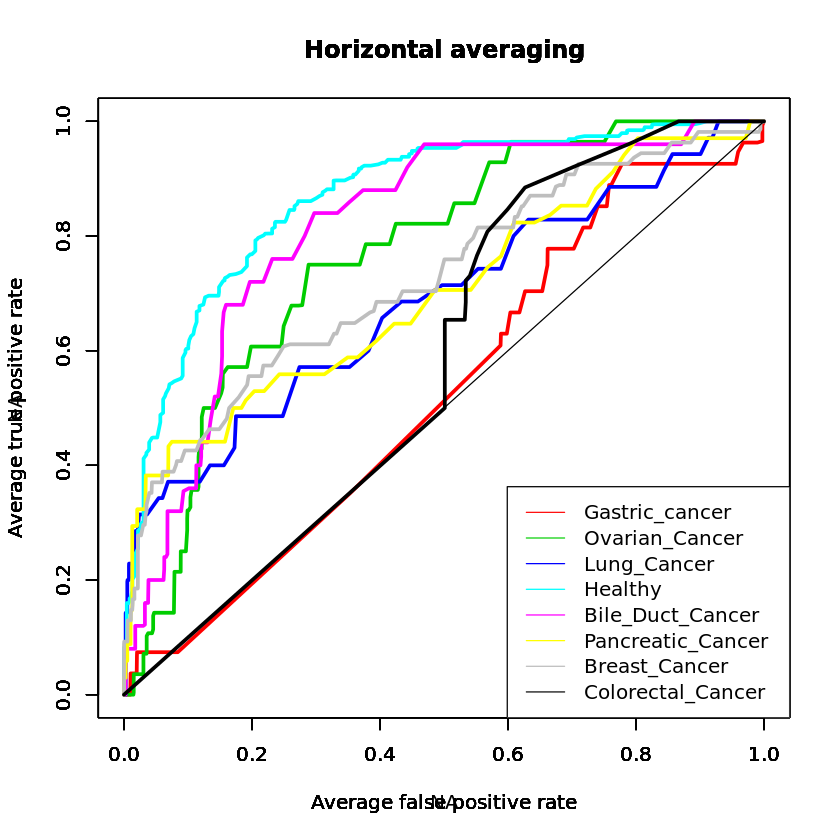

In [95]:
classes <- unique(data$sample_type)

aucs = c()


plot(x=NA, y=NA, xlim=c(0,1), ylim=c(0,1),
     bty='n')
legend_text <- c()

for (i in 1:length(classes)) {
    for (rep in 1:k_outer_cv){
        res_CV <- results %>% filter(CV_rep == rep) %>% select(-c(observed, CV_rep)) 
        class <- paste0(classes[i], "")
        pred = pull(res_CV, class)
        list.append(list_res$predictions, rep = pred)
        obs <- ifelse(data$sample_type == class, 1, 0)
        list.append(list_res$labels, rep = obs)
        }
    pred = prediction(pred, obs)
    nbperf = performance(pred, "tpr", "fpr")
    
    roc.x = unlist(nbperf@x.values)
    roc.y = unlist(nbperf@y.values)
    par(new=TRUE)
    #lines(roc.y ~ roc.x, col=i+1, lwd=2)
    plot(nbperf,
     avg='threshold',
     lwd=3,
     col=i + 1)
    legend_text <- c(legend_text, class)


    nbauc = performance(pred, "auc")
    nbauc = unlist(slot(nbauc, "y.values"))
    aucs <- c(aucs, nbauc)
    }

lines(x=c(0,1), c(0,1))
mean(aucs)
aucs
legend('bottomright', legend = legend_text, lty = 1, col=2:(length(classes)+1))